# 4. Variational Autoencoder (VAE)
<hr>

In [2]:
import importlib
import argparse
import os
import sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve

%matplotlib inline

In [4]:
import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision import transforms

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Defining parser
name = 'small_log'


parser = {
    'train': True,
    'test': True,
    'model_class': 'VAE_dropout', 
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.1,
    'scaler': 'standardization',
    'input_dir': '../input/{}/'.format(name), 
    'batch_size' : 16,
    'epochs' : 100,
    'no_cuda' : False,
    'cuda':True,
    'seed' : 7,
    'layer1': 50,
    'layer2': 20,
    'lr': 0.001,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.99,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.anomaly_pct, args.model_class)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [47]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_test = pickle.load(f)
    
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)
    
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    
    true_time = pickle.load(f)
    true_act = pickle.load(f)
    full_true_time = pickle.load(f)
    full_true_act = pickle.load(f)

In [18]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

## 1) Load data

In [10]:
# Train
input_trainLoader = torch.utils.data.DataLoader(input_train, batch_size=args.batch_size, shuffle=False, num_workers=2)
pad_index_trainLoader = torch.utils.data.DataLoader(pad_index_train, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [12]:
# dataframe
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomalous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

In [13]:
# Test
caseid_test = normal_df['CaseID'][-test_row_num:]
normal_df_test = normal_df[-test_row_num:]
anomalous_df_test = anomalous_df[-test_row_num:]

In [14]:
normal_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Activity A,1970-01-01 09:00:00,0.0,0.0
1,1,Activity B,1970-01-01 10:00:00,3600.0,3600.0
2,1,Activity C,1970-01-01 11:00:00,3600.0,7200.0
3,1,Activity D,1970-01-01 12:00:00,3600.0,10800.0
4,1,Activity E,1970-01-01 13:00:00,3600.0,14400.0


In [15]:
anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,Activity A,1970-01-01 09:00:00.000000,0.0,0.0,0,0
1,1,Activity B,1970-01-01 10:00:00.000000,3600.0,3600.0,0,0
2,1,Activity C,1970-01-01 11:00:00.000000,3600.0,7200.0,0,0
3,1,Activity D,1970-01-01 12:00:00.000000,3600.0,10800.0,0,0
4,1,Activity L,1970-01-01 13:00:00.000000,3600.0,14400.0,1,0


## 2) Build model

### Define model

In [19]:
if args.model_class == 'VAE':
    model = VAE(input_train.shape, args.layer1, args.layer2, True)

if args.model_class == 'VAE_dropout':
    model = VAE_dropout(input_train.shape, args.layer1, args.layer2, True)

if args.cuda:
    model.cuda()

./../utils\models.py:191: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2))
./../utils\models.py:192: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc21.weight, gain=np.sqrt(2))
./../utils\models.py:193: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc22.weight, gain=np.sqrt(2))
./../utils\models.py:194: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc3.weight, gain=np.sqrt(2))
./../utils\models.py:195: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc4.weight, gain=np.sqrt(2))


In [20]:
model

VAE_dropout(
  (fc1): Linear(in_features=210, out_features=50, bias=True)
  (fc21): Linear(in_features=50, out_features=20, bias=True)
  (fc22): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=210, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2)
)

### Define loss

In [21]:
def loss_function(recon_x, x, mu, logvar, avai_mask): 
    MSE = F.mse_loss(recon_x*avai_mask, x*avai_mask, size_average=False)
    # KLD = Kullback-Leibler divergence
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    loss = MSE+KLD
    return loss

### Define optimizer

In [22]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [23]:
#Adjust learning rate per epoch:

lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

## 3) Utils

In [24]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [25]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

In [26]:
def val(model, input_val, pad_index_val):
    model.eval()
    input_val = Variable(torch.Tensor(input_val).float())
    pad_index_val = Variable(torch.Tensor(pad_index_val).float())
    
    if args.cuda:
        input_val = input_val.cuda()
        pad_index_val = pad_index_val.cuda()
    
    recon_val, mu, logvar = model(input_val)  
    loss = loss_function(recon_val, input_val, mu, logvar, pad_index_val)
    return loss.data[0]/len(input_test.data)

## 4) Train

In [27]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (batch_data, batch_index) in enumerate(zip(input_trainLoader, pad_index_trainLoader)):
        
        batch_data = Variable(batch_data.float())
        batch_index = Variable(batch_index.float())

        if args.cuda:
            batch_data = batch_data.cuda()
            batch_index = batch_index.cuda()
            
        optimizer.zero_grad()
        
        recon_data, mu, logvar = model(batch_data)
        
        loss = loss_function(recon_data, batch_data, mu, logvar, batch_index)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(input_trainLoader.dataset)

In [28]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()
        
        #method 1 scheduler
        scheduler.step()
        
        train_loss = train(epoch, model, optimizer)
        end_train = time.time()
        val_score = val(model, input_val, pad_index_val)
        
        '''
        # To save model
        if epoch == 1:
            current_best = val_score
            save_model(model, epoch, val_score)
        
        else:
            if val_score < current_best:
                current_best = val_score
                save_model(model, epoch, val_score)
        '''
        
        end = time.time()
        print('====> Epoch {} | Train time: {:.4f} ms| End time: {:.4f} ms | Train loss: {:.4f} | Val loss: {:.4f}'.
              format(epoch, (end_train-init)*1000, (end-init)*1000, train_loss, val_score))
else:
    load_model(model, args.model_name)

C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


====> Epoch 1 | Train time: 2171.8054 ms| End time: 2176.8067 ms | Train loss: 170.9976 | Val loss: 39.8750
====> Epoch 2 | Train time: 1840.3587 ms| End time: 1844.3604 ms | Train loss: 57.2450 | Val loss: 27.9195
====> Epoch 3 | Train time: 1872.0646 ms| End time: 1876.0650 ms | Train loss: 39.3393 | Val loss: 22.5073
====> Epoch 4 | Train time: 1869.9610 ms| End time: 1872.9632 ms | Train loss: 30.5638 | Val loss: 19.1323
====> Epoch 5 | Train time: 1842.4690 ms| End time: 1846.4699 ms | Train loss: 26.0021 | Val loss: 16.7384
====> Epoch 6 | Train time: 1831.5916 ms| End time: 1834.5921 ms | Train loss: 22.4845 | Val loss: 15.2606
====> Epoch 7 | Train time: 1835.4535 ms| End time: 1838.4533 ms | Train loss: 20.9083 | Val loss: 14.3818
====> Epoch 8 | Train time: 1841.7718 ms| End time: 1845.7725 ms | Train loss: 18.6616 | Val loss: 13.0538
====> Epoch 9 | Train time: 1846.2858 ms| End time: 1850.2877 ms | Train loss: 17.3192 | Val loss: 12.5208
====> Epoch 10 | Train time: 1828.18

====> Epoch 79 | Train time: 1877.8536 ms| End time: 1880.8534 ms | Train loss: 6.8021 | Val loss: 6.5973
====> Epoch 80 | Train time: 1871.4426 ms| End time: 1874.4426 ms | Train loss: 6.7955 | Val loss: 6.5932
====> Epoch 81 | Train time: 1847.8889 ms| End time: 1850.8890 ms | Train loss: 6.7983 | Val loss: 6.5909
====> Epoch 82 | Train time: 1844.7657 ms| End time: 1848.7668 ms | Train loss: 6.7939 | Val loss: 6.5975
====> Epoch 83 | Train time: 1872.5069 ms| End time: 1876.5075 ms | Train loss: 6.7883 | Val loss: 6.5864
====> Epoch 84 | Train time: 1856.4589 ms| End time: 1860.4593 ms | Train loss: 6.7864 | Val loss: 6.5993
====> Epoch 85 | Train time: 1867.1916 ms| End time: 1870.1930 ms | Train loss: 6.7878 | Val loss: 6.5867
====> Epoch 86 | Train time: 1845.8381 ms| End time: 1848.8388 ms | Train loss: 6.7768 | Val loss: 6.5953
====> Epoch 87 | Train time: 1846.1785 ms| End time: 1849.1783 ms | Train loss: 6.7856 | Val loss: 6.5849
====> Epoch 88 | Train time: 1844.5117 ms| End

## 5) Predict

In [29]:
if args.test:
    input_test = Variable(torch.Tensor(input_test).float())
    if args.cuda:
        input_test = input_test.cuda()
    
    print('Predicting...')
    recon_test, mu, logvar = model(input_test)
    
    print('Separating prediction ...')
    predicted_time, predicted_activity = getPrediction(recon_test, pad_index_test)
    
    print('Done!')

Predicting...
Separating prediction ...
Done!


./../utils\utils.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_values = softmax(recon_test[i, :, 1:])


## 6) Evaluate

### Time

In [30]:
#Fix predicted time
time_df = pd.DataFrame({'CaseID': caseid_test,
                        'PredictedTime': predicted_time})

groupByCase = time_df.groupby(['CaseID'])
fixed_time_df = pd.DataFrame(columns=list(time_df))

for case, group in groupByCase:
    group.iloc[0, 1] = -mean_value/std_value
    fixed_time_df = fixed_time_df.append(group)

In [31]:
fixed_time_df.head()

,CaseID,PredictedTime
22400,1601,-0.000000
22401,1601,-1.557348
22402,1601,-1.145175
22403,1601,-0.707440
22404,1601,-0.257637


In [32]:
fixed_predicted_time = fixed_time_df['PredictedTime']

In [33]:
error = np.abs(true_time - fixed_predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

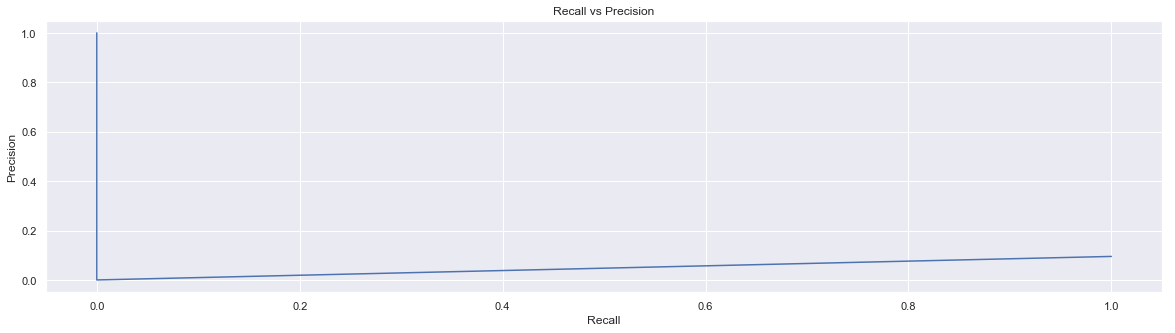

In [34]:
precision, recall, th = precision_recall_curve(error_time_df.TimeLabel.astype(int), error_time_df.Error.astype(int), pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [35]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.196322041676828


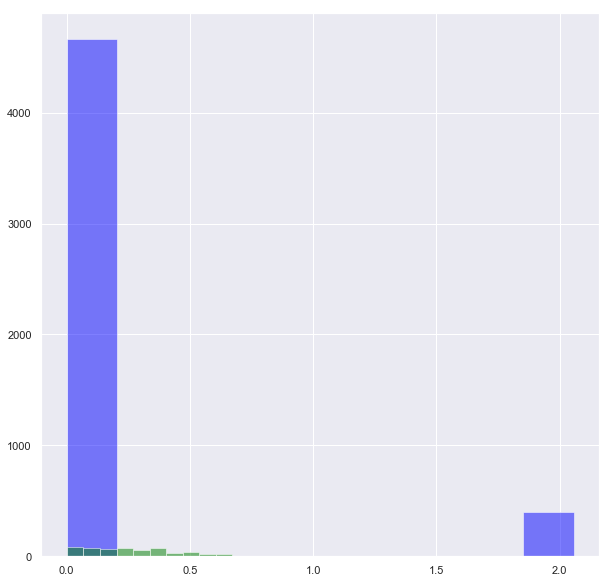

In [36]:
plotOverlapReconstructionError(error_time_df, variable='Time', output_dir=args.output_dir, save=True)

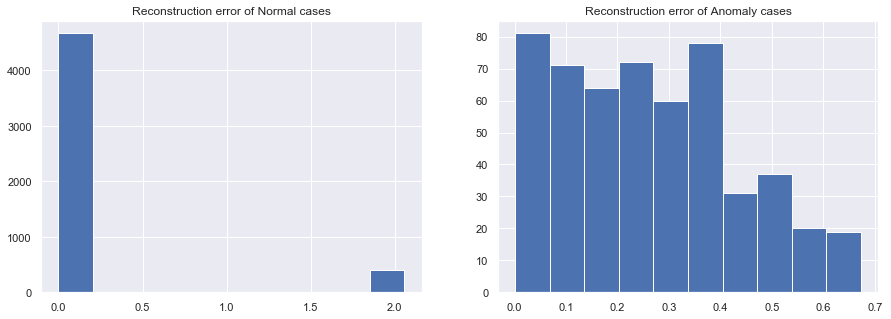

In [37]:
plotReconstructionError(error_time_df, variable='Time')

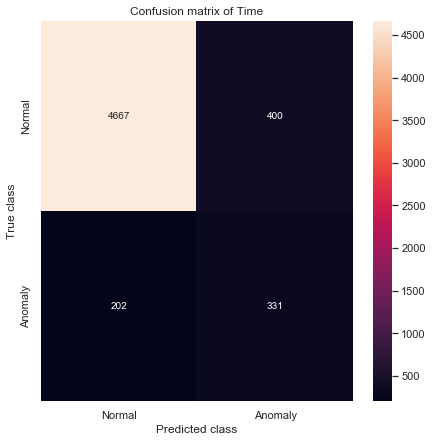

In [38]:
plotConfusionMaxtrix(error_time_df, threshold=time_threshold, variable='Time', output_dir=args.output_dir, save=True)

In [39]:
evalScore(error_time_df, threshold=time_threshold, variable='Time')

-------Evaluation of Time-------


--Weighted Evaluation--
Evaluation of Time
Precision: 0.91
Recall: 0.89
Fscore: 0.90


--Evaluation for each class--
Normal
Precision: 0.96
Recall: 0.92
Fscore: 0.94


Anomaly
Precision: 0.45
Recall: 0.62
Fscore: 0.52


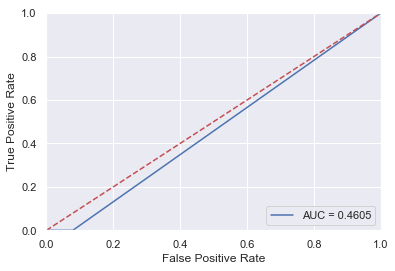

In [48]:
fpr, tpr, thresholds = roc_curve(error_time_df.TimeLabel.astype(int), error_time_df.Error.astype(int), pos_label=1)
roc_auc = auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(args.output_dir + 'ROC_time.png')
plt.show();

In [49]:
#get submission
if args.scaler == 'standardization':
    inverse_scaled_time = [x*std_value+mean_value for x in fixed_predicted_time]
else:
    inverse_scaled_time = [x*(max_value-min_value)+min_value for x in fixed_predicted_time]
    
predicted_time_label_test = [1 if e > time_threshold else 0 for e in error_time_df.Error.values]

submission_time = pd.DataFrame({'AnomalousDuration': anomalous_df_test['AnomalousDuration'].copy(),
                                'Activity': normal_df_test['Activity'].copy(),
                                'AnomalousCumDuration': anomalous_df_test['AnomalousCumDuration'].copy(),
                                'PredictedCumDuration': inverse_scaled_time,
                                'TimeLabel': time_label_test,
                                'PredictedTimeLabel': predicted_time_label_test})

In [50]:
submission_time.head()

,AnomalousDuration,Activity,AnomalousCumDuration,PredictedCumDuration,TimeLabel,PredictedTimeLabel
22400,0.0,Activity A,0.0,16679.363633,0,1
22401,3600.0,Activity B,3600.0,4051.324303,0,0
22402,3600.0,Activity C,7200.0,7393.498231,0,0
22403,3600.0,Activity D,10800.0,10942.954451,0,0
22404,3600.0,Activity E,14400.0,14590.267499,0,0


(22120.7, 28265.3)


C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


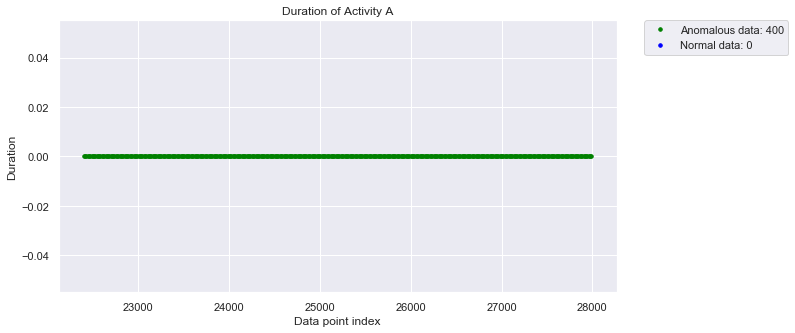

(22121.7, 28266.3)


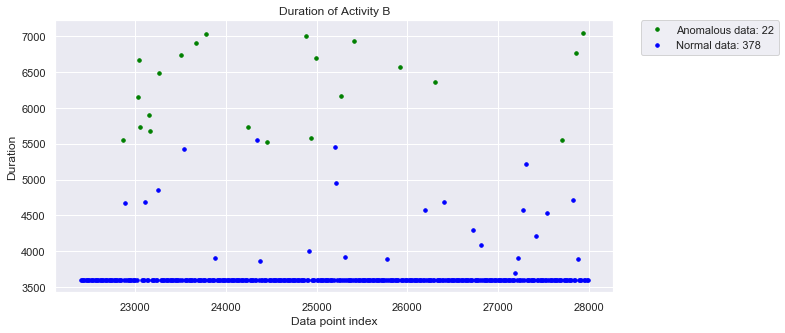

(22122.7, 28267.3)


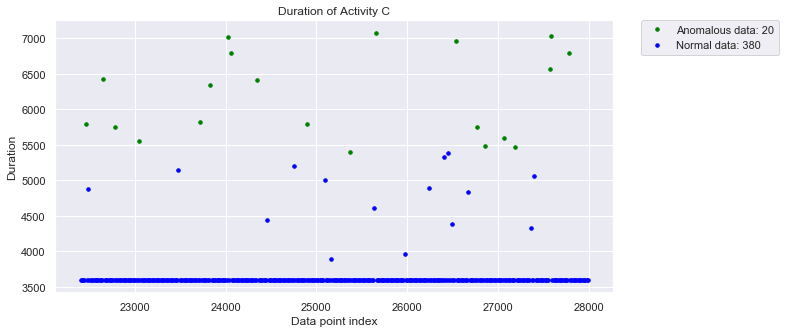

(22123.7, 28268.3)


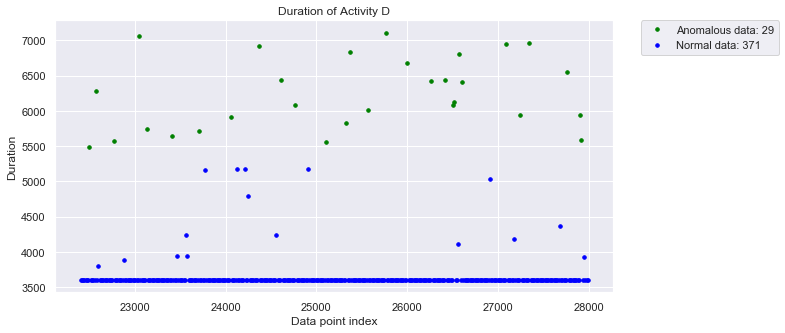

(22124.7, 28269.3)


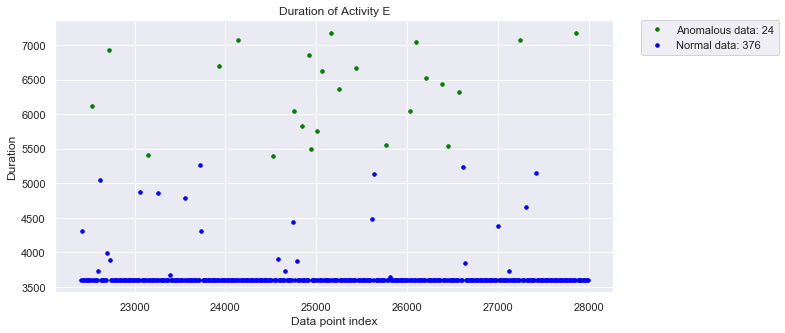

(22133.7, 28278.3)


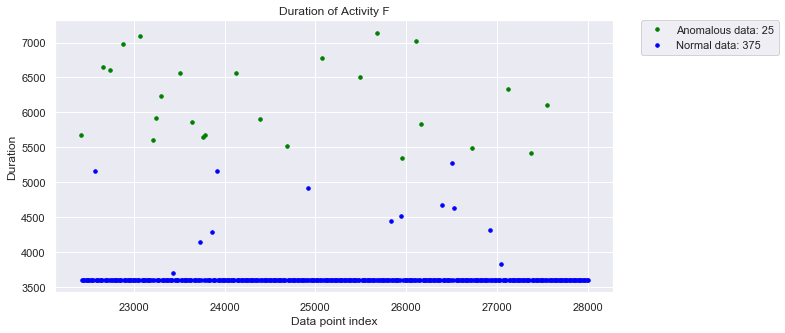

(22125.7, 28270.3)


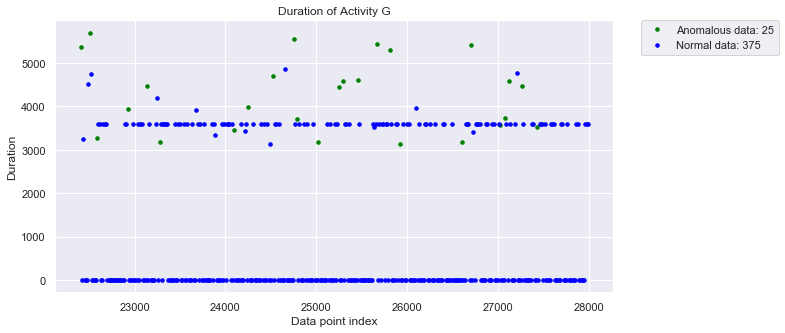

(22132.7, 28277.3)


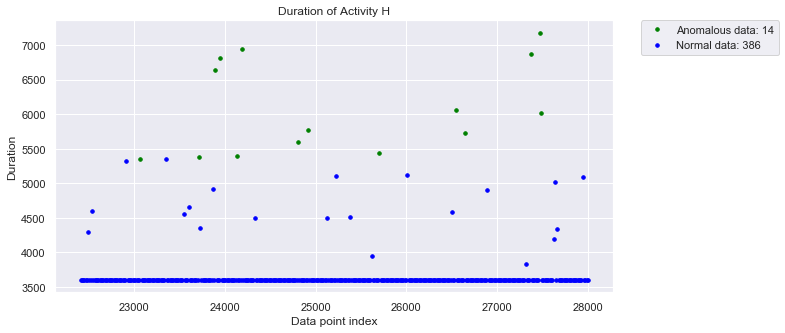

(22128.65, 28274.35)


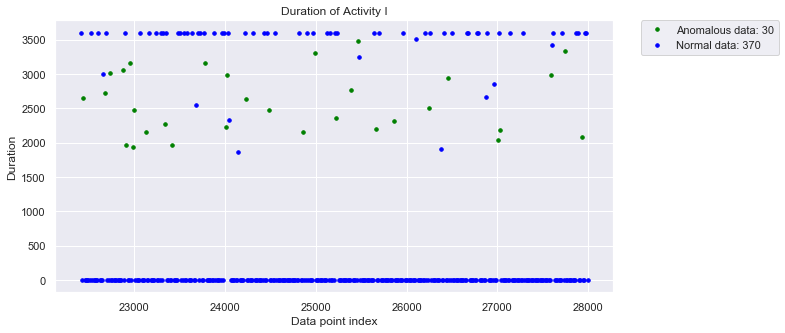

(22129.75, 28273.25)


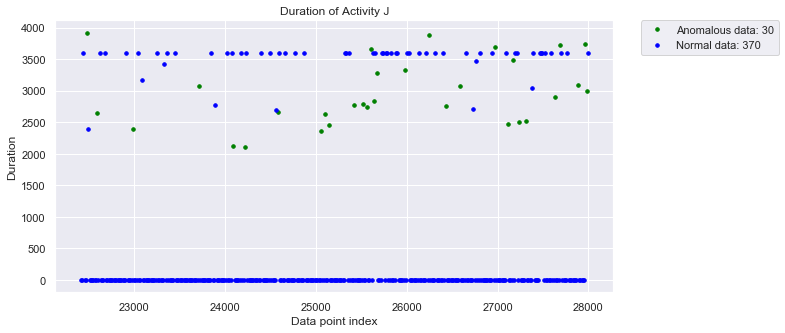

(22127.7, 28272.3)


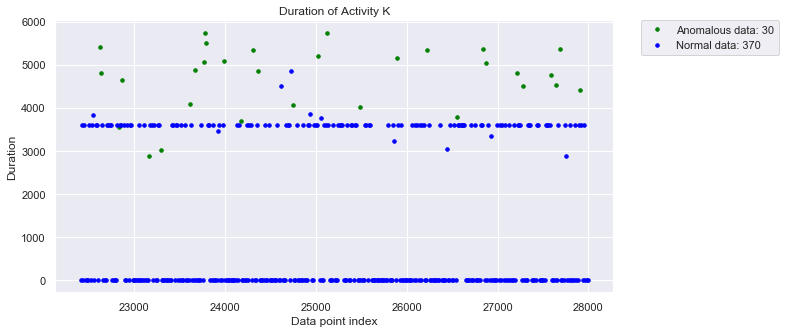

(22131.7, 28276.3)


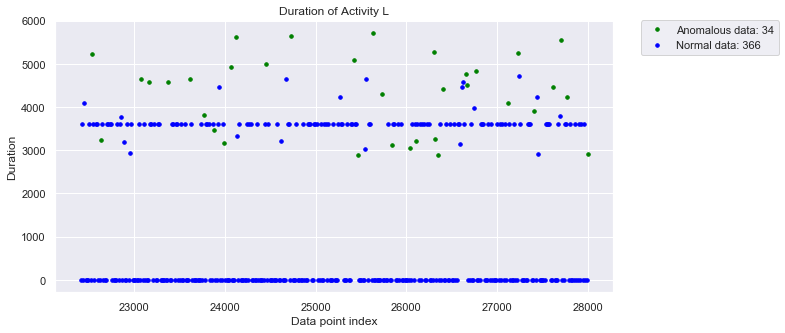

(22126.7, 28271.3)


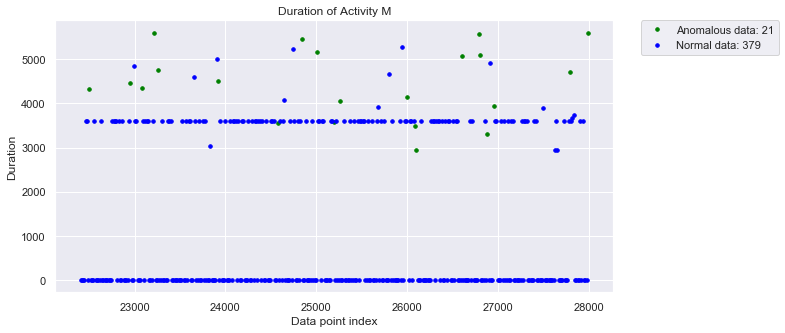

(22130.7, 28275.3)


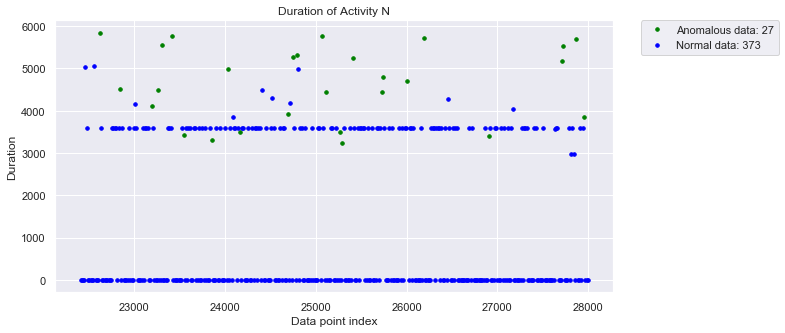

In [51]:
groupByActivity = submission_time.groupby(['Activity'])

for act, group in groupByActivity:
    plotDurationofPredictedTimeLabel(act, group, statistics_storage, args.output_dir, True)

In [52]:
submission_time.head()

,AnomalousDuration,Activity,AnomalousCumDuration,PredictedCumDuration,TimeLabel,PredictedTimeLabel
22400,0.0,Activity A,0.0,16679.363633,0,1
22401,3600.0,Activity B,3600.0,4051.324303,0,0
22402,3600.0,Activity C,7200.0,7393.498231,0,0
22403,3600.0,Activity D,10800.0,10942.954451,0,0
22404,3600.0,Activity E,14400.0,14590.267499,0,0


In [53]:
statistics_storage

{'Activity A': {'mean': 0.0, 'std': 0.0},
 'Activity B': {'mean': 3600.0, 'std': 0.0},
 'Activity C': {'mean': 3600.0, 'std': 0.0},
 'Activity D': {'mean': 3600.0, 'std': 0.0},
 'Activity E': {'mean': 3600.0, 'std': 0.0},
 'Activity F': {'mean': 3600.0, 'std': 0.0},
 'Activity G': {'mean': 1186.2, 'std': 1692.537119519216},
 'Activity H': {'mean': 3600.0, 'std': 0.0},
 'Activity I': {'mean': 558.0, 'std': 1303.1826973111965},
 'Activity J': {'mean': 628.2, 'std': 1366.681626910443},
 'Activity K': {'mean': 1186.2, 'std': 1692.5371195192167},
 'Activity L': {'mean': 1186.2, 'std': 1692.5371195192167},
 'Activity M': {'mean': 1227.6, 'std': 1706.9900842049221},
 'Activity N': {'mean': 1227.6, 'std': 1706.9900842049221}}

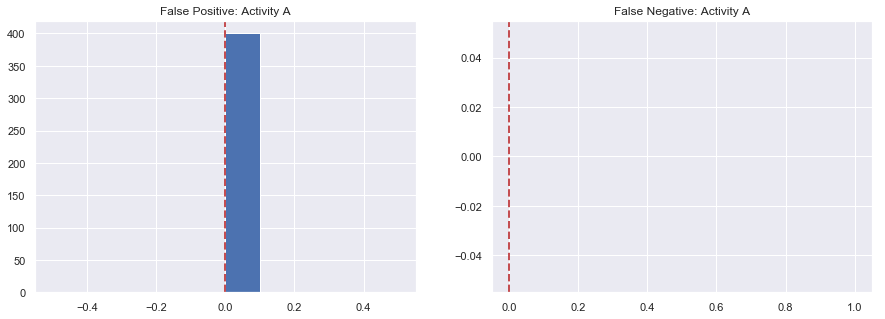

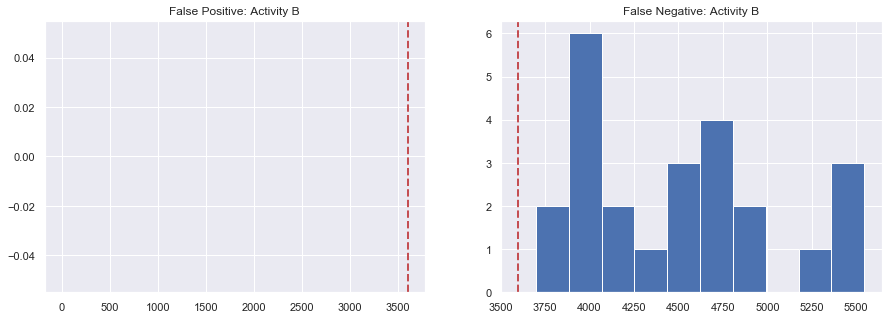

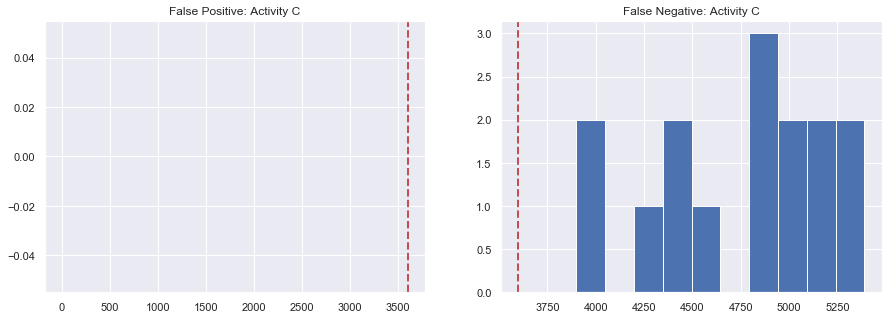

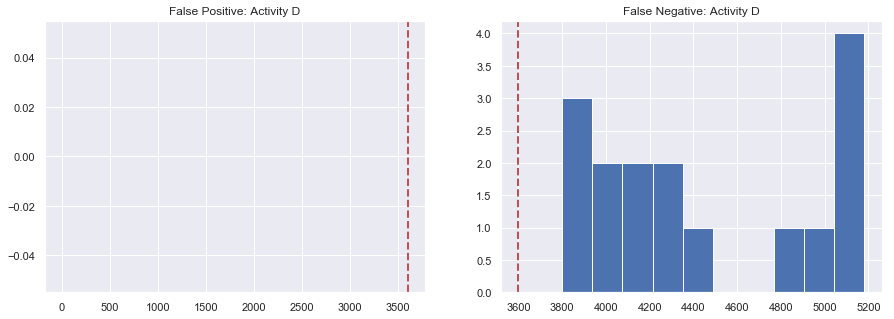

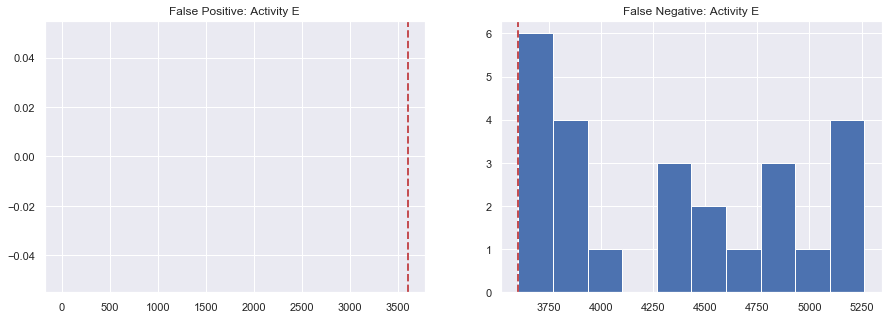

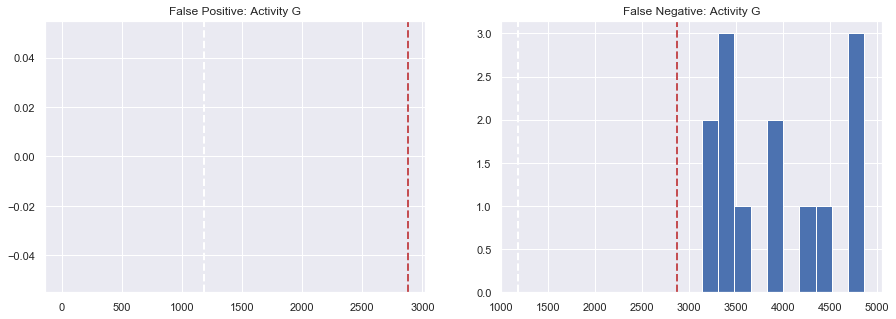

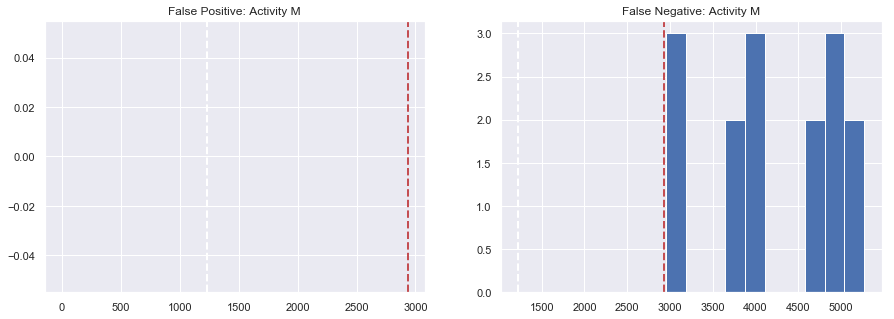

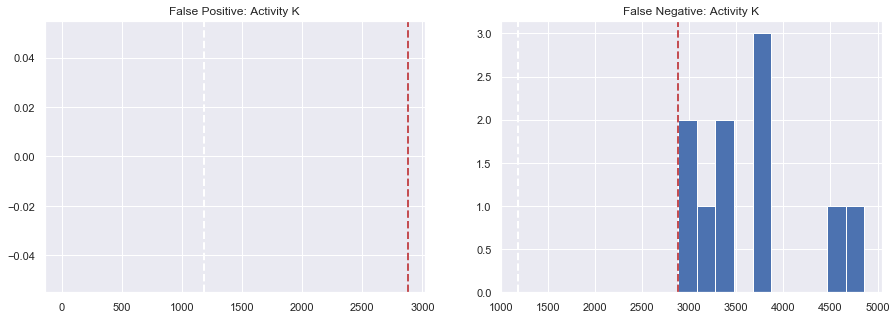

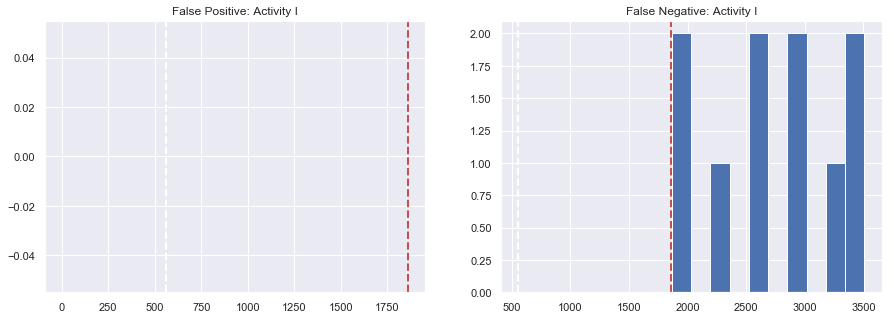

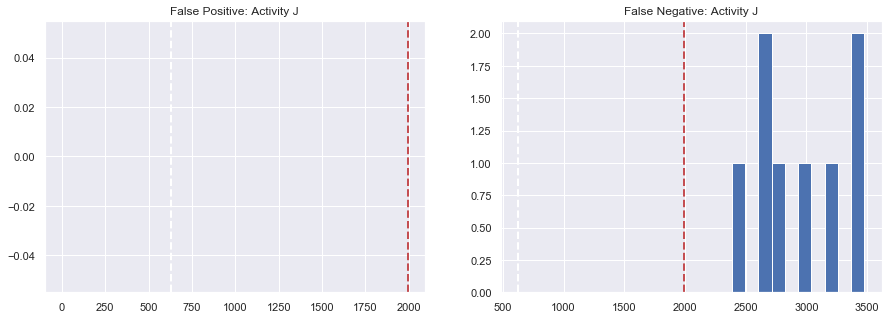

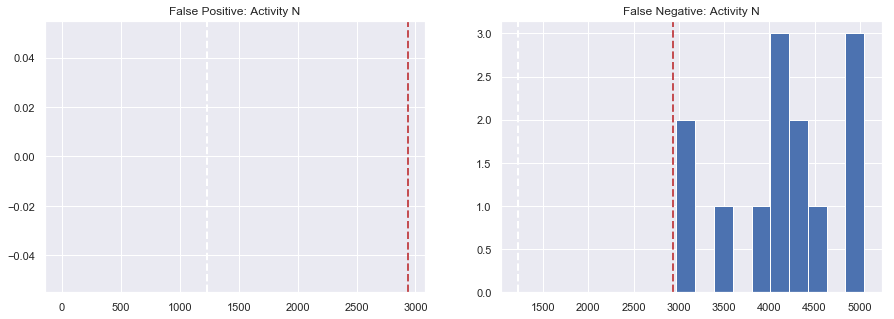

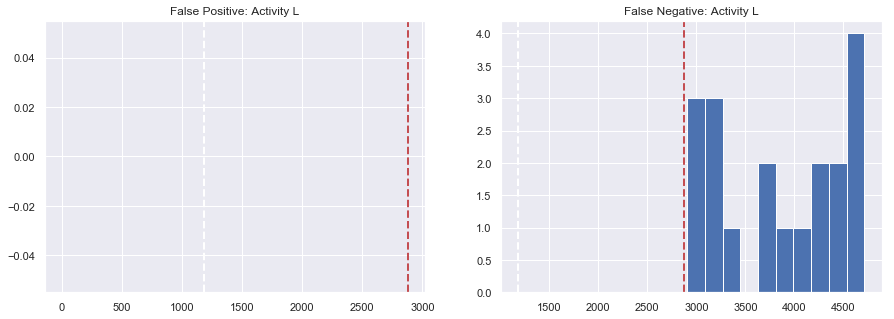

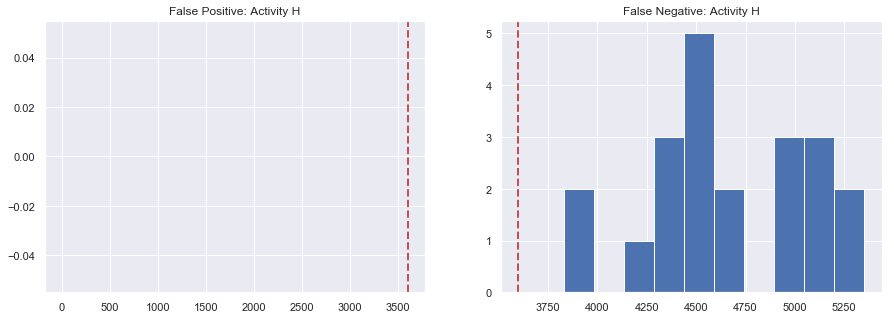

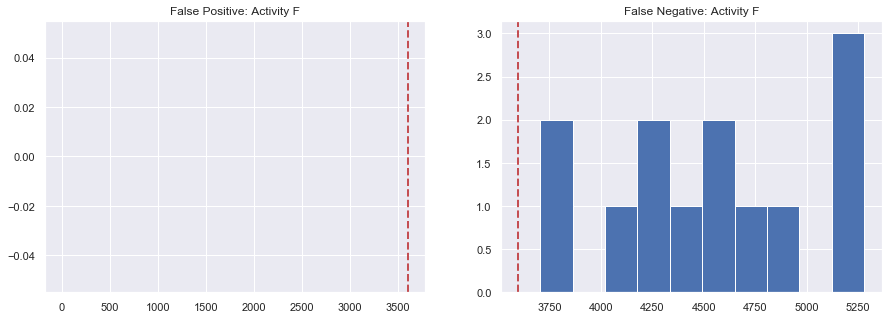

In [54]:
act_list = [i for i in submission_time['Activity'].unique()]
false_positive_df = submission_time[(submission_time['PredictedTimeLabel']== 1)&(submission_time['TimeLabel']== 0)]
false_negative_df = submission_time[(submission_time['PredictedTimeLabel']== 0)&(submission_time['TimeLabel']== 1)]

for act in act_list:
    plotFalseDuration(false_positive_df, false_negative_df, act, statistics_storage)

### Activity

#### i) Threshold based

In [55]:
# error = np.mean(np.power(true_act - predicted_activity, 2), axis = 1)
error = np.mean(np.abs(true_act - predicted_activity), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [56]:
error_activity_df.head()

,Error,ActivityLabel
22400,0.120764,0
22401,0.120491,0
22402,0.120533,0
22403,0.120570,0
22404,0.120359,0


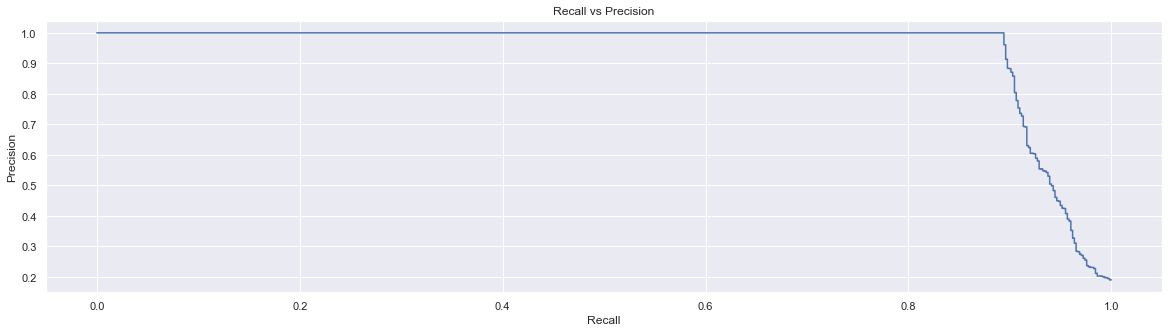

In [57]:
precision, recall, th = precision_recall_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [58]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.12624950001519966


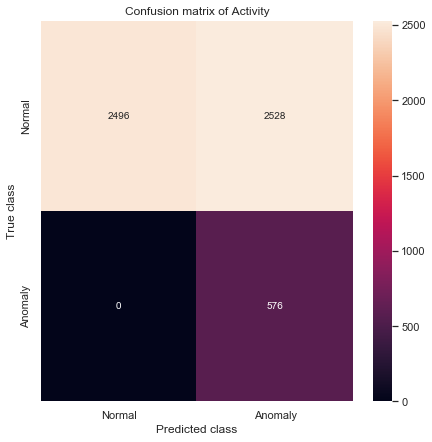

In [59]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity', output_dir=args.output_dir, save=True)

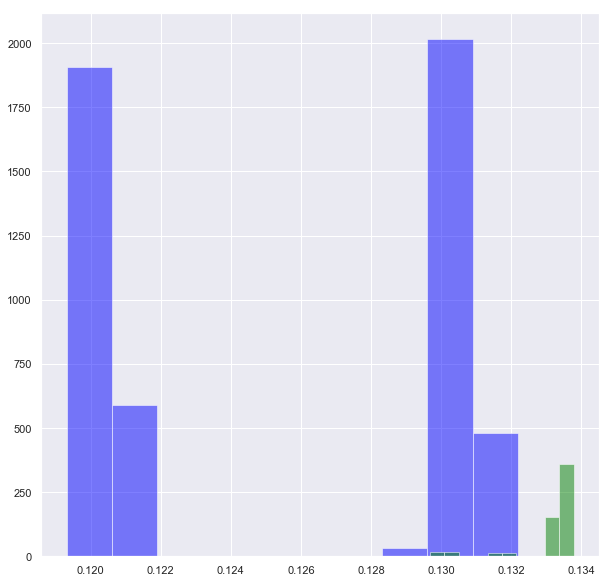

In [60]:
plotOverlapReconstructionError(error_activity_df, variable='Activity', output_dir=args.output_dir, save=True)

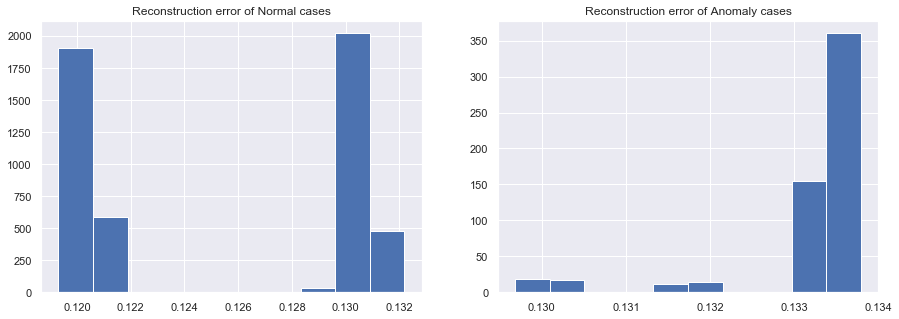

In [61]:
plotReconstructionError(error_activity_df)

In [62]:
evalScore(error_activity_df, 0.24, variable='Activity')

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation of Activity
Precision: 0.80
Recall: 0.90
Fscore: 0.85


--Evaluation for each class--
Normal
Precision: 0.90
Recall: 1.00
Fscore: 0.95


Anomaly
Precision: 0.00
Recall: 0.00
Fscore: 0.00


C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


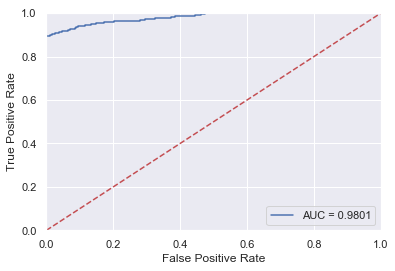

In [63]:
fpr, tpr, thresholds = roc_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(args.output_dir+'ROC_Act.png')
plt.show();

#### Argmax based

In [64]:
# evaluate based on classification
predicted_act_df = pd.DataFrame(data=predicted_activity, columns=list(true_act))
predicted_act_label = predicted_act_df.idxmax(axis=1)
true_act_label = true_act.idxmax(axis=1)
predicted_time_label = [0 if a==b else 1 for a, b in zip(true_act_label,predicted_act_label)]

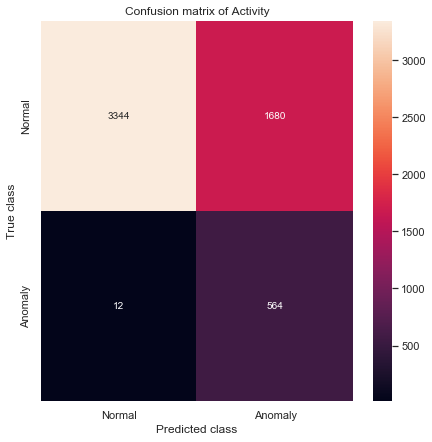

In [65]:
#plot confusion matrix
LABELS = ['Normal', 'Anomaly']
matrix = confusion_matrix(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
plt.figure(figsize=(7, 7))
sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title('Confusion matrix of Activity')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [66]:
score = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label, average='weighted')
    
print('-------Evaluation of Activity-------')
print('\n')
print('--Weighted Evaluation--')
print('Evaluation')
print('Precision: {:.2f}'.format(score[0]))
print('Recall: {:.2f}'.format(score[1]))
print('Fscore: {:.2f}'.format(score[2]))
print('\n')
score_1 = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
print('--Evaluation for each class--')
print('Normal')
print('Precision: {:.2f}'.format(score_1[0][0]))
print('Recall: {:.2f}'.format(score_1[1][0]))
print('Fscore: {:.2f}'.format(score_1[2][0]))
print('\n')
print('Anomaly')
print('Precision: {:.2f}'.format(score_1[0][1]))
print('Recall: {:.2f}'.format(score_1[1][1]))
print('Fscore: {:.2f}'.format(score_1[2][1]))

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation
Precision: 0.92
Recall: 0.70
Fscore: 0.76


--Evaluation for each class--
Normal
Precision: 1.00
Recall: 0.67
Fscore: 0.80


Anomaly
Precision: 0.25
Recall: 0.98
Fscore: 0.40


In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(true_act_label, predicted_act_label)

0.5992857142857143